# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    data_transformer = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    training_set = datasets.ImageFolder(data_dir,data_transformer)
    data_loader = torch.utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

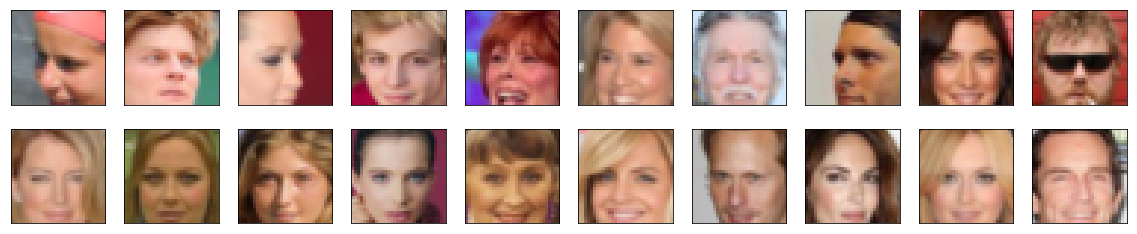

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max = feature_range
    x = (max-min)*x + min
    
    return x
    


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8588)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels= out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32 input
        self.Conv1 = conv(3,conv_dim,4,batch_norm=False)
        # 16x16 out
        self.Conv2 = conv(conv_dim,conv_dim*2,4,batch_norm=True)
        # 8x8 out
        self.Conv3 = conv(conv_dim*2,conv_dim*4,4,batch_norm=True)
        # 4x4 out
        self.Conv4 = conv(conv_dim*4,conv_dim*8,4,batch_norm=True)
        # 2x2 out
        self.Fc = nn.Linear(conv_dim*8*2*2,1)
        self.Dropout = nn.Dropout(0.2)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.Conv1(x),0.2)
        x = F.leaky_relu(self.Conv2(x),0.2)
        x = F.leaky_relu(self.Conv3(x),0.2)
        x = F.leaky_relu(self.Conv4(x),0.2)
        
        # flatten
        x = x.view(-1,self.conv_dim*8*2*2)
        
        # the  final output layer
        x = self.Dropout(x)
        x = self.Fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# make helper deconv function before generator
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.de_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.de_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.de_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.de_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu 
        x = F.relu(self.de_conv1(x))
        x = F.relu(self.de_conv2(x))
        x = F.relu(self.de_conv3(x))        
        # last layer + tanh activation
        x = self.de_conv4(x)
        x = F.tanh(x)
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:

        init.normal_(m.weight.data, 0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (Conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Fc): Linear(in_features=1024, out_features=1, bias=True)
  (Dropout): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (de_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size)
    
    # if GPU available  move labels GPU     
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()

        
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    
    # if GPU available  move labels GPU     

    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss
    

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.2
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])


---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
from tqdm import tqdm

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

        
    # epoch training loop
    
    for epoch in tqdm(range(n_epochs)):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step() 


            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute discriminator losses on fake images 
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 35


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

  0%|          | 0/35 [00:00<?, ?it/s]

Epoch [    1/   35] | d_loss: 1.4038 | g_loss: 0.9612
Epoch [    1/   35] | d_loss: 0.3913 | g_loss: 3.1217
Epoch [    1/   35] | d_loss: 0.1730 | g_loss: 3.6091
Epoch [    1/   35] | d_loss: 0.0936 | g_loss: 4.2615
Epoch [    1/   35] | d_loss: 0.0373 | g_loss: 4.6806
Epoch [    1/   35] | d_loss: 0.0274 | g_loss: 5.1382
Epoch [    1/   35] | d_loss: 0.4764 | g_loss: 4.2050
Epoch [    1/   35] | d_loss: 0.1361 | g_loss: 3.4056
Epoch [    1/   35] | d_loss: 0.1884 | g_loss: 4.0782
Epoch [    1/   35] | d_loss: 1.6096 | g_loss: 2.8013
Epoch [    1/   35] | d_loss: 0.1679 | g_loss: 3.0159
Epoch [    1/   35] | d_loss: 0.3713 | g_loss: 2.0833
Epoch [    1/   35] | d_loss: 3.2909 | g_loss: 3.3586
Epoch [    1/   35] | d_loss: 0.4667 | g_loss: 2.0454
Epoch [    1/   35] | d_loss: 0.8053 | g_loss: 3.6657
Epoch [    1/   35] | d_loss: 0.8123 | g_loss: 1.3557
Epoch [    1/   35] | d_loss: 1.2162 | g_loss: 3.3401
Epoch [    1/   35] | d_loss: 1.3333 | g_loss: 0.7889
Epoch [    1/   35] | d_loss

  3%|▎         | 1/35 [01:33<53:03, 93.62s/it]

Epoch [    2/   35] | d_loss: 1.1636 | g_loss: 0.8450
Epoch [    2/   35] | d_loss: 0.9985 | g_loss: 1.7685
Epoch [    2/   35] | d_loss: 1.0373 | g_loss: 1.1219
Epoch [    2/   35] | d_loss: 0.9808 | g_loss: 1.2403
Epoch [    2/   35] | d_loss: 1.2543 | g_loss: 0.7502
Epoch [    2/   35] | d_loss: 0.9274 | g_loss: 2.0017
Epoch [    2/   35] | d_loss: 1.1183 | g_loss: 1.3667
Epoch [    2/   35] | d_loss: 0.9555 | g_loss: 1.1451
Epoch [    2/   35] | d_loss: 1.3536 | g_loss: 2.3322
Epoch [    2/   35] | d_loss: 1.1750 | g_loss: 1.0137
Epoch [    2/   35] | d_loss: 1.2520 | g_loss: 0.7615
Epoch [    2/   35] | d_loss: 1.2911 | g_loss: 0.8328
Epoch [    2/   35] | d_loss: 1.0797 | g_loss: 1.4449
Epoch [    2/   35] | d_loss: 1.0754 | g_loss: 1.2093
Epoch [    2/   35] | d_loss: 1.4513 | g_loss: 2.0359
Epoch [    2/   35] | d_loss: 1.2248 | g_loss: 1.4291
Epoch [    2/   35] | d_loss: 1.3236 | g_loss: 0.7025
Epoch [    2/   35] | d_loss: 1.2708 | g_loss: 2.1146
Epoch [    2/   35] | d_loss

  6%|▌         | 2/35 [03:06<51:19, 93.32s/it]

Epoch [    3/   35] | d_loss: 1.0450 | g_loss: 2.1658
Epoch [    3/   35] | d_loss: 1.0195 | g_loss: 1.6207
Epoch [    3/   35] | d_loss: 1.0818 | g_loss: 2.0497
Epoch [    3/   35] | d_loss: 1.1483 | g_loss: 1.0207
Epoch [    3/   35] | d_loss: 1.0085 | g_loss: 1.2235
Epoch [    3/   35] | d_loss: 0.9976 | g_loss: 0.8725
Epoch [    3/   35] | d_loss: 1.0311 | g_loss: 1.3113
Epoch [    3/   35] | d_loss: 1.0865 | g_loss: 0.7699
Epoch [    3/   35] | d_loss: 1.0244 | g_loss: 1.1743
Epoch [    3/   35] | d_loss: 0.9942 | g_loss: 1.8263
Epoch [    3/   35] | d_loss: 0.8514 | g_loss: 1.3677
Epoch [    3/   35] | d_loss: 1.4035 | g_loss: 2.7447
Epoch [    3/   35] | d_loss: 1.1299 | g_loss: 0.7116
Epoch [    3/   35] | d_loss: 0.9121 | g_loss: 1.4482
Epoch [    3/   35] | d_loss: 0.8510 | g_loss: 1.4097
Epoch [    3/   35] | d_loss: 1.0018 | g_loss: 2.1907
Epoch [    3/   35] | d_loss: 0.9314 | g_loss: 1.1568
Epoch [    3/   35] | d_loss: 0.8713 | g_loss: 2.0518
Epoch [    3/   35] | d_loss

  9%|▊         | 3/35 [04:39<49:41, 93.18s/it]

Epoch [    4/   35] | d_loss: 1.0384 | g_loss: 1.0199
Epoch [    4/   35] | d_loss: 0.8259 | g_loss: 1.5156
Epoch [    4/   35] | d_loss: 0.8466 | g_loss: 1.4120
Epoch [    4/   35] | d_loss: 0.8022 | g_loss: 1.6819
Epoch [    4/   35] | d_loss: 0.8678 | g_loss: 1.5859
Epoch [    4/   35] | d_loss: 0.8027 | g_loss: 1.4719
Epoch [    4/   35] | d_loss: 1.0796 | g_loss: 0.7983
Epoch [    4/   35] | d_loss: 1.0320 | g_loss: 1.4329
Epoch [    4/   35] | d_loss: 0.8866 | g_loss: 1.5539
Epoch [    4/   35] | d_loss: 0.8639 | g_loss: 1.1108
Epoch [    4/   35] | d_loss: 0.8302 | g_loss: 2.2765
Epoch [    4/   35] | d_loss: 1.0080 | g_loss: 1.1314
Epoch [    4/   35] | d_loss: 0.9158 | g_loss: 1.8555
Epoch [    4/   35] | d_loss: 0.7859 | g_loss: 2.4543
Epoch [    4/   35] | d_loss: 1.2959 | g_loss: 2.2752
Epoch [    4/   35] | d_loss: 1.0178 | g_loss: 2.2037
Epoch [    4/   35] | d_loss: 0.9908 | g_loss: 1.2221
Epoch [    4/   35] | d_loss: 1.1209 | g_loss: 2.1217
Epoch [    4/   35] | d_loss

 11%|█▏        | 4/35 [06:12<48:07, 93.15s/it]

Epoch [    5/   35] | d_loss: 1.5104 | g_loss: 2.0401
Epoch [    5/   35] | d_loss: 0.9755 | g_loss: 2.4264
Epoch [    5/   35] | d_loss: 0.8325 | g_loss: 1.6253
Epoch [    5/   35] | d_loss: 1.4107 | g_loss: 2.6448
Epoch [    5/   35] | d_loss: 0.9351 | g_loss: 2.1489
Epoch [    5/   35] | d_loss: 1.0323 | g_loss: 0.9174
Epoch [    5/   35] | d_loss: 1.1987 | g_loss: 2.6555
Epoch [    5/   35] | d_loss: 0.6269 | g_loss: 1.3699
Epoch [    5/   35] | d_loss: 1.0864 | g_loss: 0.9257
Epoch [    5/   35] | d_loss: 0.9364 | g_loss: 2.6942
Epoch [    5/   35] | d_loss: 0.8078 | g_loss: 2.0133
Epoch [    5/   35] | d_loss: 0.9372 | g_loss: 1.9682
Epoch [    5/   35] | d_loss: 1.3317 | g_loss: 0.7759
Epoch [    5/   35] | d_loss: 0.6819 | g_loss: 1.7837
Epoch [    5/   35] | d_loss: 1.2136 | g_loss: 3.0171
Epoch [    5/   35] | d_loss: 1.1748 | g_loss: 0.7746
Epoch [    5/   35] | d_loss: 0.8619 | g_loss: 1.1088
Epoch [    5/   35] | d_loss: 0.6899 | g_loss: 1.5372
Epoch [    5/   35] | d_loss

 14%|█▍        | 5/35 [07:45<46:34, 93.14s/it]

Epoch [    6/   35] | d_loss: 0.6389 | g_loss: 1.9081
Epoch [    6/   35] | d_loss: 0.9539 | g_loss: 1.6874
Epoch [    6/   35] | d_loss: 0.9494 | g_loss: 2.1396
Epoch [    6/   35] | d_loss: 0.6716 | g_loss: 1.4402
Epoch [    6/   35] | d_loss: 0.6295 | g_loss: 1.7859
Epoch [    6/   35] | d_loss: 0.8624 | g_loss: 1.5120
Epoch [    6/   35] | d_loss: 1.0713 | g_loss: 2.7267
Epoch [    6/   35] | d_loss: 0.8468 | g_loss: 2.8939
Epoch [    6/   35] | d_loss: 0.8757 | g_loss: 1.5721
Epoch [    6/   35] | d_loss: 0.9803 | g_loss: 2.4322
Epoch [    6/   35] | d_loss: 0.7879 | g_loss: 1.5942
Epoch [    6/   35] | d_loss: 0.8123 | g_loss: 2.4335
Epoch [    6/   35] | d_loss: 1.0223 | g_loss: 1.3444
Epoch [    6/   35] | d_loss: 0.6600 | g_loss: 1.8246
Epoch [    6/   35] | d_loss: 0.7184 | g_loss: 1.9075
Epoch [    6/   35] | d_loss: 1.3619 | g_loss: 3.1549
Epoch [    6/   35] | d_loss: 0.7534 | g_loss: 1.1100
Epoch [    6/   35] | d_loss: 0.6122 | g_loss: 1.8338
Epoch [    6/   35] | d_loss

 17%|█▋        | 6/35 [09:18<44:58, 93.07s/it]

Epoch [    7/   35] | d_loss: 0.7608 | g_loss: 2.5816
Epoch [    7/   35] | d_loss: 0.6529 | g_loss: 2.6941
Epoch [    7/   35] | d_loss: 0.5711 | g_loss: 1.7241
Epoch [    7/   35] | d_loss: 0.8502 | g_loss: 2.8707
Epoch [    7/   35] | d_loss: 0.8957 | g_loss: 1.4525
Epoch [    7/   35] | d_loss: 1.1036 | g_loss: 2.5093
Epoch [    7/   35] | d_loss: 0.6671 | g_loss: 1.4482
Epoch [    7/   35] | d_loss: 1.2082 | g_loss: 0.9631
Epoch [    7/   35] | d_loss: 0.9722 | g_loss: 0.8800
Epoch [    7/   35] | d_loss: 0.7193 | g_loss: 2.7069
Epoch [    7/   35] | d_loss: 0.8280 | g_loss: 0.7639
Epoch [    7/   35] | d_loss: 1.4381 | g_loss: 1.5288
Epoch [    7/   35] | d_loss: 0.7737 | g_loss: 2.4037
Epoch [    7/   35] | d_loss: 0.6738 | g_loss: 1.8047
Epoch [    7/   35] | d_loss: 0.4546 | g_loss: 1.7705
Epoch [    7/   35] | d_loss: 0.7627 | g_loss: 1.4135
Epoch [    7/   35] | d_loss: 0.8559 | g_loss: 1.1754
Epoch [    7/   35] | d_loss: 0.6764 | g_loss: 2.1962
Epoch [    7/   35] | d_loss

 20%|██        | 7/35 [10:51<43:25, 93.05s/it]

Epoch [    8/   35] | d_loss: 0.9566 | g_loss: 3.0571
Epoch [    8/   35] | d_loss: 1.0131 | g_loss: 2.9306
Epoch [    8/   35] | d_loss: 0.6250 | g_loss: 2.4843
Epoch [    8/   35] | d_loss: 0.6021 | g_loss: 1.6888
Epoch [    8/   35] | d_loss: 0.5616 | g_loss: 2.3530
Epoch [    8/   35] | d_loss: 0.6184 | g_loss: 2.5975
Epoch [    8/   35] | d_loss: 1.0396 | g_loss: 4.4078
Epoch [    8/   35] | d_loss: 0.7644 | g_loss: 2.3107
Epoch [    8/   35] | d_loss: 0.6391 | g_loss: 1.5053
Epoch [    8/   35] | d_loss: 0.7899 | g_loss: 2.6582
Epoch [    8/   35] | d_loss: 0.7903 | g_loss: 1.4752
Epoch [    8/   35] | d_loss: 0.6916 | g_loss: 2.1862
Epoch [    8/   35] | d_loss: 1.0082 | g_loss: 0.7743
Epoch [    8/   35] | d_loss: 0.8100 | g_loss: 1.6070
Epoch [    8/   35] | d_loss: 1.0188 | g_loss: 2.4464
Epoch [    8/   35] | d_loss: 0.8926 | g_loss: 2.6018
Epoch [    8/   35] | d_loss: 0.7751 | g_loss: 3.3880
Epoch [    8/   35] | d_loss: 0.4193 | g_loss: 1.7913
Epoch [    8/   35] | d_loss

 23%|██▎       | 8/35 [12:24<41:52, 93.06s/it]

Epoch [    9/   35] | d_loss: 0.7412 | g_loss: 1.9483
Epoch [    9/   35] | d_loss: 0.9190 | g_loss: 0.7724
Epoch [    9/   35] | d_loss: 0.9366 | g_loss: 1.3780
Epoch [    9/   35] | d_loss: 0.6046 | g_loss: 1.5335
Epoch [    9/   35] | d_loss: 0.6492 | g_loss: 2.2420
Epoch [    9/   35] | d_loss: 0.5356 | g_loss: 2.5428
Epoch [    9/   35] | d_loss: 0.5371 | g_loss: 2.2293
Epoch [    9/   35] | d_loss: 0.6661 | g_loss: 1.7944
Epoch [    9/   35] | d_loss: 0.8280 | g_loss: 2.0349
Epoch [    9/   35] | d_loss: 0.5524 | g_loss: 2.5363
Epoch [    9/   35] | d_loss: 0.5619 | g_loss: 1.5870
Epoch [    9/   35] | d_loss: 0.6438 | g_loss: 2.6310
Epoch [    9/   35] | d_loss: 0.6539 | g_loss: 3.0067
Epoch [    9/   35] | d_loss: 0.6520 | g_loss: 3.1921
Epoch [    9/   35] | d_loss: 0.9804 | g_loss: 1.4668
Epoch [    9/   35] | d_loss: 0.5505 | g_loss: 1.9775
Epoch [    9/   35] | d_loss: 0.6916 | g_loss: 2.8841
Epoch [    9/   35] | d_loss: 0.4920 | g_loss: 1.9875
Epoch [    9/   35] | d_loss

 26%|██▌       | 9/35 [13:57<40:20, 93.10s/it]

Epoch [   10/   35] | d_loss: 0.6597 | g_loss: 3.5559
Epoch [   10/   35] | d_loss: 0.8083 | g_loss: 1.3156
Epoch [   10/   35] | d_loss: 0.4592 | g_loss: 1.6897
Epoch [   10/   35] | d_loss: 0.5003 | g_loss: 1.4261
Epoch [   10/   35] | d_loss: 0.6274 | g_loss: 3.3077
Epoch [   10/   35] | d_loss: 0.6827 | g_loss: 2.0817
Epoch [   10/   35] | d_loss: 0.7827 | g_loss: 1.4021
Epoch [   10/   35] | d_loss: 0.7870 | g_loss: 1.6253
Epoch [   10/   35] | d_loss: 0.4726 | g_loss: 1.8815
Epoch [   10/   35] | d_loss: 0.8809 | g_loss: 3.9276
Epoch [   10/   35] | d_loss: 0.4656 | g_loss: 2.2703
Epoch [   10/   35] | d_loss: 0.5566 | g_loss: 2.0937
Epoch [   10/   35] | d_loss: 0.4867 | g_loss: 2.2106
Epoch [   10/   35] | d_loss: 0.4819 | g_loss: 3.1364
Epoch [   10/   35] | d_loss: 0.6783 | g_loss: 1.0317
Epoch [   10/   35] | d_loss: 0.5670 | g_loss: 2.7443
Epoch [   10/   35] | d_loss: 0.4532 | g_loss: 1.9986
Epoch [   10/   35] | d_loss: 0.6077 | g_loss: 3.0958
Epoch [   10/   35] | d_loss

 29%|██▊       | 10/35 [15:30<38:46, 93.08s/it]

Epoch [   11/   35] | d_loss: 0.8019 | g_loss: 1.8253
Epoch [   11/   35] | d_loss: 0.4908 | g_loss: 2.0159
Epoch [   11/   35] | d_loss: 0.3923 | g_loss: 2.2526
Epoch [   11/   35] | d_loss: 0.7116 | g_loss: 2.1613
Epoch [   11/   35] | d_loss: 0.5936 | g_loss: 3.6840
Epoch [   11/   35] | d_loss: 0.6677 | g_loss: 3.9402
Epoch [   11/   35] | d_loss: 0.3416 | g_loss: 3.5135
Epoch [   11/   35] | d_loss: 0.3552 | g_loss: 2.8345
Epoch [   11/   35] | d_loss: 0.3380 | g_loss: 2.9585
Epoch [   11/   35] | d_loss: 0.6225 | g_loss: 1.7124
Epoch [   11/   35] | d_loss: 0.5457 | g_loss: 3.3531
Epoch [   11/   35] | d_loss: 0.4533 | g_loss: 2.1008
Epoch [   11/   35] | d_loss: 0.5501 | g_loss: 1.7118
Epoch [   11/   35] | d_loss: 0.9550 | g_loss: 1.1973
Epoch [   11/   35] | d_loss: 0.5488 | g_loss: 2.6576
Epoch [   11/   35] | d_loss: 0.8751 | g_loss: 4.3157
Epoch [   11/   35] | d_loss: 0.5142 | g_loss: 3.3005
Epoch [   11/   35] | d_loss: 0.7086 | g_loss: 1.1755
Epoch [   11/   35] | d_loss

 31%|███▏      | 11/35 [17:03<37:12, 93.02s/it]

Epoch [   12/   35] | d_loss: 2.0900 | g_loss: 4.6426
Epoch [   12/   35] | d_loss: 0.5131 | g_loss: 2.1002
Epoch [   12/   35] | d_loss: 0.4374 | g_loss: 1.9027
Epoch [   12/   35] | d_loss: 0.9160 | g_loss: 3.7638
Epoch [   12/   35] | d_loss: 0.8166 | g_loss: 2.8110
Epoch [   12/   35] | d_loss: 0.4285 | g_loss: 2.7773
Epoch [   12/   35] | d_loss: 0.6291 | g_loss: 1.8801
Epoch [   12/   35] | d_loss: 0.2918 | g_loss: 3.1802
Epoch [   12/   35] | d_loss: 0.3923 | g_loss: 2.1403
Epoch [   12/   35] | d_loss: 0.4989 | g_loss: 1.9401
Epoch [   12/   35] | d_loss: 0.4347 | g_loss: 2.7949
Epoch [   12/   35] | d_loss: 0.7021 | g_loss: 0.5816
Epoch [   12/   35] | d_loss: 0.6051 | g_loss: 1.8063
Epoch [   12/   35] | d_loss: 0.7124 | g_loss: 0.6985
Epoch [   12/   35] | d_loss: 0.2990 | g_loss: 2.3629
Epoch [   12/   35] | d_loss: 0.6641 | g_loss: 1.6929
Epoch [   12/   35] | d_loss: 0.4168 | g_loss: 2.0337
Epoch [   12/   35] | d_loss: 0.4825 | g_loss: 2.6161
Epoch [   12/   35] | d_loss

 34%|███▍      | 12/35 [18:35<35:36, 92.90s/it]

Epoch [   13/   35] | d_loss: 0.8011 | g_loss: 3.4260
Epoch [   13/   35] | d_loss: 0.2778 | g_loss: 2.7063
Epoch [   13/   35] | d_loss: 0.4171 | g_loss: 3.6346
Epoch [   13/   35] | d_loss: 0.5549 | g_loss: 1.8767
Epoch [   13/   35] | d_loss: 1.2124 | g_loss: 1.7068
Epoch [   13/   35] | d_loss: 0.3741 | g_loss: 1.7464
Epoch [   13/   35] | d_loss: 0.5683 | g_loss: 1.4030
Epoch [   13/   35] | d_loss: 0.4865 | g_loss: 4.1713
Epoch [   13/   35] | d_loss: 0.5038 | g_loss: 3.5078
Epoch [   13/   35] | d_loss: 0.2715 | g_loss: 2.9147
Epoch [   13/   35] | d_loss: 0.6710 | g_loss: 4.7548
Epoch [   13/   35] | d_loss: 0.5610 | g_loss: 3.1462
Epoch [   13/   35] | d_loss: 0.3794 | g_loss: 2.3593
Epoch [   13/   35] | d_loss: 1.0685 | g_loss: 2.3346
Epoch [   13/   35] | d_loss: 0.7445 | g_loss: 1.0964
Epoch [   13/   35] | d_loss: 0.4567 | g_loss: 2.2310
Epoch [   13/   35] | d_loss: 0.3586 | g_loss: 1.5561
Epoch [   13/   35] | d_loss: 0.3893 | g_loss: 2.4870
Epoch [   13/   35] | d_loss

 37%|███▋      | 13/35 [20:08<34:02, 92.82s/it]

Epoch [   14/   35] | d_loss: 0.4030 | g_loss: 2.8398
Epoch [   14/   35] | d_loss: 0.4859 | g_loss: 1.8851
Epoch [   14/   35] | d_loss: 0.2930 | g_loss: 2.8279
Epoch [   14/   35] | d_loss: 0.5254 | g_loss: 1.8438
Epoch [   14/   35] | d_loss: 0.3658 | g_loss: 1.9648
Epoch [   14/   35] | d_loss: 0.4490 | g_loss: 2.6639
Epoch [   14/   35] | d_loss: 0.4248 | g_loss: 2.3205
Epoch [   14/   35] | d_loss: 0.3358 | g_loss: 2.7535
Epoch [   14/   35] | d_loss: 0.6348 | g_loss: 2.3422
Epoch [   14/   35] | d_loss: 0.3604 | g_loss: 3.1680
Epoch [   14/   35] | d_loss: 0.4214 | g_loss: 2.7222
Epoch [   14/   35] | d_loss: 0.9554 | g_loss: 4.9742
Epoch [   14/   35] | d_loss: 0.5437 | g_loss: 4.0764
Epoch [   14/   35] | d_loss: 1.7548 | g_loss: 3.4156
Epoch [   14/   35] | d_loss: 0.3127 | g_loss: 2.7154
Epoch [   14/   35] | d_loss: 1.0663 | g_loss: 1.2281
Epoch [   14/   35] | d_loss: 0.3912 | g_loss: 3.9317
Epoch [   14/   35] | d_loss: 0.5744 | g_loss: 2.0286
Epoch [   14/   35] | d_loss

 40%|████      | 14/35 [21:41<32:29, 92.82s/it]

Epoch [   15/   35] | d_loss: 0.5095 | g_loss: 3.1990
Epoch [   15/   35] | d_loss: 0.3460 | g_loss: 3.4332
Epoch [   15/   35] | d_loss: 0.6611 | g_loss: 1.8955
Epoch [   15/   35] | d_loss: 0.6152 | g_loss: 1.3921
Epoch [   15/   35] | d_loss: 0.2665 | g_loss: 3.7113
Epoch [   15/   35] | d_loss: 0.5604 | g_loss: 3.8640
Epoch [   15/   35] | d_loss: 0.6071 | g_loss: 4.3295
Epoch [   15/   35] | d_loss: 0.5113 | g_loss: 3.0759
Epoch [   15/   35] | d_loss: 0.3512 | g_loss: 2.4144
Epoch [   15/   35] | d_loss: 0.4273 | g_loss: 2.7223
Epoch [   15/   35] | d_loss: 0.8766 | g_loss: 1.9693
Epoch [   15/   35] | d_loss: 0.2466 | g_loss: 2.8434
Epoch [   15/   35] | d_loss: 0.2365 | g_loss: 3.1498
Epoch [   15/   35] | d_loss: 0.2986 | g_loss: 3.2097
Epoch [   15/   35] | d_loss: 1.9864 | g_loss: 0.7342
Epoch [   15/   35] | d_loss: 0.2609 | g_loss: 2.8943
Epoch [   15/   35] | d_loss: 0.3370 | g_loss: 3.7677
Epoch [   15/   35] | d_loss: 0.3678 | g_loss: 3.7887
Epoch [   15/   35] | d_loss

 43%|████▎     | 15/35 [23:14<31:00, 93.01s/it]

Epoch [   16/   35] | d_loss: 0.7869 | g_loss: 3.4635
Epoch [   16/   35] | d_loss: 0.5310 | g_loss: 5.0884
Epoch [   16/   35] | d_loss: 0.6364 | g_loss: 1.9928
Epoch [   16/   35] | d_loss: 0.2882 | g_loss: 2.9204
Epoch [   16/   35] | d_loss: 0.2296 | g_loss: 3.5676
Epoch [   16/   35] | d_loss: 0.6083 | g_loss: 5.0672
Epoch [   16/   35] | d_loss: 0.5977 | g_loss: 1.7318
Epoch [   16/   35] | d_loss: 0.4361 | g_loss: 3.6119
Epoch [   16/   35] | d_loss: 0.3410 | g_loss: 2.5430
Epoch [   16/   35] | d_loss: 0.2044 | g_loss: 3.9043
Epoch [   16/   35] | d_loss: 0.2420 | g_loss: 3.5048
Epoch [   16/   35] | d_loss: 0.1667 | g_loss: 3.6776
Epoch [   16/   35] | d_loss: 0.3297 | g_loss: 3.4118
Epoch [   16/   35] | d_loss: 1.3139 | g_loss: 0.8798
Epoch [   16/   35] | d_loss: 0.4078 | g_loss: 3.3611
Epoch [   16/   35] | d_loss: 0.3889 | g_loss: 1.7221
Epoch [   16/   35] | d_loss: 1.3891 | g_loss: 0.5476
Epoch [   16/   35] | d_loss: 0.3734 | g_loss: 2.7469
Epoch [   16/   35] | d_loss

 46%|████▌     | 16/35 [24:47<29:27, 93.03s/it]

Epoch [   17/   35] | d_loss: 0.1527 | g_loss: 3.7003
Epoch [   17/   35] | d_loss: 0.3544 | g_loss: 3.7269
Epoch [   17/   35] | d_loss: 0.3759 | g_loss: 3.9071
Epoch [   17/   35] | d_loss: 0.7958 | g_loss: 3.8354
Epoch [   17/   35] | d_loss: 0.6160 | g_loss: 2.2878
Epoch [   17/   35] | d_loss: 0.3236 | g_loss: 4.7978
Epoch [   17/   35] | d_loss: 0.5178 | g_loss: 3.7507
Epoch [   17/   35] | d_loss: 0.2554 | g_loss: 3.5681
Epoch [   17/   35] | d_loss: 0.2092 | g_loss: 3.2134
Epoch [   17/   35] | d_loss: 0.8523 | g_loss: 1.6172
Epoch [   17/   35] | d_loss: 0.3816 | g_loss: 3.2711
Epoch [   17/   35] | d_loss: 0.3230 | g_loss: 3.2957
Epoch [   17/   35] | d_loss: 0.7004 | g_loss: 5.3552
Epoch [   17/   35] | d_loss: 0.5998 | g_loss: 4.5801
Epoch [   17/   35] | d_loss: 0.2289 | g_loss: 3.6820
Epoch [   17/   35] | d_loss: 0.2176 | g_loss: 3.3411
Epoch [   17/   35] | d_loss: 0.2600 | g_loss: 3.4800
Epoch [   17/   35] | d_loss: 0.6659 | g_loss: 4.2263
Epoch [   17/   35] | d_loss

 49%|████▊     | 17/35 [26:20<27:52, 92.90s/it]

Epoch [   18/   35] | d_loss: 0.5171 | g_loss: 2.2690
Epoch [   18/   35] | d_loss: 0.5804 | g_loss: 2.4573
Epoch [   18/   35] | d_loss: 0.3084 | g_loss: 4.3382
Epoch [   18/   35] | d_loss: 0.4372 | g_loss: 4.1583
Epoch [   18/   35] | d_loss: 1.6278 | g_loss: 6.3877
Epoch [   18/   35] | d_loss: 0.2620 | g_loss: 4.0713
Epoch [   18/   35] | d_loss: 0.2473 | g_loss: 3.5881
Epoch [   18/   35] | d_loss: 0.3740 | g_loss: 3.9520
Epoch [   18/   35] | d_loss: 1.9943 | g_loss: 1.4326
Epoch [   18/   35] | d_loss: 0.8454 | g_loss: 4.6853
Epoch [   18/   35] | d_loss: 0.2393 | g_loss: 3.7496
Epoch [   18/   35] | d_loss: 0.8195 | g_loss: 5.4053
Epoch [   18/   35] | d_loss: 0.3068 | g_loss: 2.5284
Epoch [   18/   35] | d_loss: 0.4668 | g_loss: 5.1356
Epoch [   18/   35] | d_loss: 0.1886 | g_loss: 3.7830
Epoch [   18/   35] | d_loss: 0.3616 | g_loss: 4.9248
Epoch [   18/   35] | d_loss: 0.1250 | g_loss: 4.2701
Epoch [   18/   35] | d_loss: 0.2587 | g_loss: 3.3443
Epoch [   18/   35] | d_loss

 51%|█████▏    | 18/35 [27:53<26:19, 92.91s/it]

Epoch [   19/   35] | d_loss: 0.2880 | g_loss: 3.5249
Epoch [   19/   35] | d_loss: 0.2263 | g_loss: 3.2813
Epoch [   19/   35] | d_loss: 0.8452 | g_loss: 4.4495
Epoch [   19/   35] | d_loss: 0.4251 | g_loss: 2.8717
Epoch [   19/   35] | d_loss: 0.5247 | g_loss: 2.6170
Epoch [   19/   35] | d_loss: 0.3483 | g_loss: 3.8771
Epoch [   19/   35] | d_loss: 0.2196 | g_loss: 3.7228
Epoch [   19/   35] | d_loss: 0.3394 | g_loss: 2.2188
Epoch [   19/   35] | d_loss: 0.2890 | g_loss: 2.6472
Epoch [   19/   35] | d_loss: 0.3128 | g_loss: 2.9826
Epoch [   19/   35] | d_loss: 0.1566 | g_loss: 4.4888
Epoch [   19/   35] | d_loss: 0.2466 | g_loss: 4.6981
Epoch [   19/   35] | d_loss: 0.2035 | g_loss: 2.2195
Epoch [   19/   35] | d_loss: 0.3196 | g_loss: 2.8487
Epoch [   19/   35] | d_loss: 0.3419 | g_loss: 3.8422
Epoch [   19/   35] | d_loss: 0.2562 | g_loss: 4.1290
Epoch [   19/   35] | d_loss: 1.3071 | g_loss: 6.2114
Epoch [   19/   35] | d_loss: 0.1704 | g_loss: 3.3388
Epoch [   19/   35] | d_loss

 54%|█████▍    | 19/35 [29:26<24:47, 92.94s/it]

Epoch [   20/   35] | d_loss: 0.1873 | g_loss: 4.3431
Epoch [   20/   35] | d_loss: 0.1692 | g_loss: 4.4149
Epoch [   20/   35] | d_loss: 0.4468 | g_loss: 2.8562
Epoch [   20/   35] | d_loss: 0.5561 | g_loss: 5.5563
Epoch [   20/   35] | d_loss: 0.1192 | g_loss: 3.4626
Epoch [   20/   35] | d_loss: 0.4301 | g_loss: 3.5241
Epoch [   20/   35] | d_loss: 0.1787 | g_loss: 4.6865
Epoch [   20/   35] | d_loss: 0.8440 | g_loss: 4.8884
Epoch [   20/   35] | d_loss: 1.2873 | g_loss: 7.8049
Epoch [   20/   35] | d_loss: 0.1685 | g_loss: 2.9199
Epoch [   20/   35] | d_loss: 0.2566 | g_loss: 3.3385
Epoch [   20/   35] | d_loss: 0.2654 | g_loss: 3.4056
Epoch [   20/   35] | d_loss: 0.2826 | g_loss: 5.1143
Epoch [   20/   35] | d_loss: 0.3742 | g_loss: 2.5695
Epoch [   20/   35] | d_loss: 0.5547 | g_loss: 1.3036
Epoch [   20/   35] | d_loss: 0.5142 | g_loss: 3.0746
Epoch [   20/   35] | d_loss: 0.3242 | g_loss: 3.7207
Epoch [   20/   35] | d_loss: 0.2081 | g_loss: 3.9700
Epoch [   20/   35] | d_loss

 57%|█████▋    | 20/35 [30:59<23:14, 92.96s/it]

Epoch [   21/   35] | d_loss: 0.4097 | g_loss: 4.1988
Epoch [   21/   35] | d_loss: 0.3831 | g_loss: 5.2414
Epoch [   21/   35] | d_loss: 0.2161 | g_loss: 3.9472
Epoch [   21/   35] | d_loss: 0.2239 | g_loss: 4.9204
Epoch [   21/   35] | d_loss: 0.3089 | g_loss: 3.0647
Epoch [   21/   35] | d_loss: 1.6646 | g_loss: 6.7756
Epoch [   21/   35] | d_loss: 0.3091 | g_loss: 5.0487
Epoch [   21/   35] | d_loss: 0.1807 | g_loss: 4.7733
Epoch [   21/   35] | d_loss: 0.2587 | g_loss: 4.4849
Epoch [   21/   35] | d_loss: 0.1978 | g_loss: 3.2906
Epoch [   21/   35] | d_loss: 0.0911 | g_loss: 4.2324
Epoch [   21/   35] | d_loss: 0.2513 | g_loss: 3.1144
Epoch [   21/   35] | d_loss: 0.1977 | g_loss: 4.8838
Epoch [   21/   35] | d_loss: 0.8462 | g_loss: 7.5934
Epoch [   21/   35] | d_loss: 0.2615 | g_loss: 2.4279
Epoch [   21/   35] | d_loss: 0.2476 | g_loss: 3.5563
Epoch [   21/   35] | d_loss: 0.4971 | g_loss: 6.6299
Epoch [   21/   35] | d_loss: 0.6122 | g_loss: 2.7073
Epoch [   21/   35] | d_loss

 60%|██████    | 21/35 [32:32<21:41, 92.94s/it]

Epoch [   22/   35] | d_loss: 0.7280 | g_loss: 7.7419
Epoch [   22/   35] | d_loss: 0.5103 | g_loss: 2.7920
Epoch [   22/   35] | d_loss: 0.1376 | g_loss: 3.8284
Epoch [   22/   35] | d_loss: 0.4369 | g_loss: 6.6308
Epoch [   22/   35] | d_loss: 0.5314 | g_loss: 2.6623
Epoch [   22/   35] | d_loss: 1.1025 | g_loss: 5.7082
Epoch [   22/   35] | d_loss: 0.2885 | g_loss: 6.0370
Epoch [   22/   35] | d_loss: 0.1363 | g_loss: 4.2506
Epoch [   22/   35] | d_loss: 0.1235 | g_loss: 4.2323
Epoch [   22/   35] | d_loss: 0.1418 | g_loss: 3.2901
Epoch [   22/   35] | d_loss: 0.0796 | g_loss: 3.1317
Epoch [   22/   35] | d_loss: 0.1460 | g_loss: 4.2249
Epoch [   22/   35] | d_loss: 0.2350 | g_loss: 4.0836
Epoch [   22/   35] | d_loss: 0.1938 | g_loss: 3.8909
Epoch [   22/   35] | d_loss: 0.2696 | g_loss: 3.3687
Epoch [   22/   35] | d_loss: 0.2845 | g_loss: 1.9339
Epoch [   22/   35] | d_loss: 0.6103 | g_loss: 2.5187
Epoch [   22/   35] | d_loss: 0.3145 | g_loss: 3.0072
Epoch [   22/   35] | d_loss

 63%|██████▎   | 22/35 [34:05<20:07, 92.91s/it]

Epoch [   23/   35] | d_loss: 1.5621 | g_loss: 1.1187
Epoch [   23/   35] | d_loss: 0.1759 | g_loss: 4.8297
Epoch [   23/   35] | d_loss: 0.3512 | g_loss: 4.6064
Epoch [   23/   35] | d_loss: 0.1226 | g_loss: 4.0863
Epoch [   23/   35] | d_loss: 0.2246 | g_loss: 2.9830
Epoch [   23/   35] | d_loss: 0.0876 | g_loss: 4.6323
Epoch [   23/   35] | d_loss: 0.1359 | g_loss: 4.1943
Epoch [   23/   35] | d_loss: 0.2019 | g_loss: 3.8769
Epoch [   23/   35] | d_loss: 0.1818 | g_loss: 4.9797
Epoch [   23/   35] | d_loss: 0.5809 | g_loss: 1.5039
Epoch [   23/   35] | d_loss: 0.0895 | g_loss: 2.7656
Epoch [   23/   35] | d_loss: 1.0534 | g_loss: 4.5621
Epoch [   23/   35] | d_loss: 0.0779 | g_loss: 4.6580
Epoch [   23/   35] | d_loss: 0.2769 | g_loss: 2.7882
Epoch [   23/   35] | d_loss: 0.1201 | g_loss: 3.4041
Epoch [   23/   35] | d_loss: 0.5504 | g_loss: 5.3574
Epoch [   23/   35] | d_loss: 0.3773 | g_loss: 1.7418
Epoch [   23/   35] | d_loss: 0.5695 | g_loss: 5.7624
Epoch [   23/   35] | d_loss

 66%|██████▌   | 23/35 [35:38<18:34, 92.90s/it]

Epoch [   24/   35] | d_loss: 2.3189 | g_loss: 0.1290
Epoch [   24/   35] | d_loss: 0.3278 | g_loss: 2.1877
Epoch [   24/   35] | d_loss: 1.3930 | g_loss: 2.0709
Epoch [   24/   35] | d_loss: 0.5269 | g_loss: 3.5724
Epoch [   24/   35] | d_loss: 1.5922 | g_loss: 4.7843
Epoch [   24/   35] | d_loss: 0.2261 | g_loss: 3.9900
Epoch [   24/   35] | d_loss: 0.1188 | g_loss: 4.0272
Epoch [   24/   35] | d_loss: 0.1029 | g_loss: 3.6939
Epoch [   24/   35] | d_loss: 0.1588 | g_loss: 4.1974
Epoch [   24/   35] | d_loss: 0.4983 | g_loss: 1.3003
Epoch [   24/   35] | d_loss: 0.2477 | g_loss: 2.7924
Epoch [   24/   35] | d_loss: 0.8436 | g_loss: 6.7797
Epoch [   24/   35] | d_loss: 0.3738 | g_loss: 2.5929
Epoch [   24/   35] | d_loss: 0.3152 | g_loss: 3.3100
Epoch [   24/   35] | d_loss: 0.2922 | g_loss: 6.9072
Epoch [   24/   35] | d_loss: 0.2986 | g_loss: 2.3260
Epoch [   24/   35] | d_loss: 0.3224 | g_loss: 2.7427
Epoch [   24/   35] | d_loss: 0.1723 | g_loss: 3.8821
Epoch [   24/   35] | d_loss

 69%|██████▊   | 24/35 [37:10<17:00, 92.81s/it]

Epoch [   25/   35] | d_loss: 0.2284 | g_loss: 5.8242
Epoch [   25/   35] | d_loss: 0.2378 | g_loss: 3.4969
Epoch [   25/   35] | d_loss: 0.2211 | g_loss: 4.5529
Epoch [   25/   35] | d_loss: 0.1539 | g_loss: 6.0616
Epoch [   25/   35] | d_loss: 0.8978 | g_loss: 1.7336
Epoch [   25/   35] | d_loss: 0.1722 | g_loss: 2.4768
Epoch [   25/   35] | d_loss: 0.3497 | g_loss: 5.0426
Epoch [   25/   35] | d_loss: 0.2001 | g_loss: 2.4684
Epoch [   25/   35] | d_loss: 0.3008 | g_loss: 2.0806
Epoch [   25/   35] | d_loss: 0.2715 | g_loss: 3.7876
Epoch [   25/   35] | d_loss: 0.1834 | g_loss: 4.2763
Epoch [   25/   35] | d_loss: 0.1464 | g_loss: 3.3393
Epoch [   25/   35] | d_loss: 0.2374 | g_loss: 5.1013
Epoch [   25/   35] | d_loss: 0.1892 | g_loss: 3.8455
Epoch [   25/   35] | d_loss: 0.4889 | g_loss: 2.7674
Epoch [   25/   35] | d_loss: 0.3700 | g_loss: 3.0639
Epoch [   25/   35] | d_loss: 0.5024 | g_loss: 2.9202
Epoch [   25/   35] | d_loss: 0.2616 | g_loss: 4.4376
Epoch [   25/   35] | d_loss

 71%|███████▏  | 25/35 [38:43<15:28, 92.87s/it]

Epoch [   26/   35] | d_loss: 0.1621 | g_loss: 3.2017
Epoch [   26/   35] | d_loss: 0.1265 | g_loss: 3.6350
Epoch [   26/   35] | d_loss: 0.2206 | g_loss: 3.6563
Epoch [   26/   35] | d_loss: 0.3674 | g_loss: 3.9921
Epoch [   26/   35] | d_loss: 0.2451 | g_loss: 3.7853
Epoch [   26/   35] | d_loss: 0.0735 | g_loss: 3.2277
Epoch [   26/   35] | d_loss: 0.5019 | g_loss: 5.6101
Epoch [   26/   35] | d_loss: 0.2374 | g_loss: 4.1983
Epoch [   26/   35] | d_loss: 0.5311 | g_loss: 1.8093
Epoch [   26/   35] | d_loss: 0.1886 | g_loss: 4.7870
Epoch [   26/   35] | d_loss: 0.7788 | g_loss: 0.7247
Epoch [   26/   35] | d_loss: 0.3206 | g_loss: 2.3816
Epoch [   26/   35] | d_loss: 0.1231 | g_loss: 4.1145
Epoch [   26/   35] | d_loss: 0.2196 | g_loss: 3.7576
Epoch [   26/   35] | d_loss: 0.1865 | g_loss: 4.1462
Epoch [   26/   35] | d_loss: 0.0759 | g_loss: 3.6892
Epoch [   26/   35] | d_loss: 0.1167 | g_loss: 4.2077
Epoch [   26/   35] | d_loss: 0.1482 | g_loss: 4.7889
Epoch [   26/   35] | d_loss

 74%|███████▍  | 26/35 [40:16<13:56, 92.94s/it]

Epoch [   27/   35] | d_loss: 0.0657 | g_loss: 5.1812
Epoch [   27/   35] | d_loss: 1.7642 | g_loss: 3.6173
Epoch [   27/   35] | d_loss: 0.1549 | g_loss: 4.6556
Epoch [   27/   35] | d_loss: 0.0754 | g_loss: 4.6936
Epoch [   27/   35] | d_loss: 0.3407 | g_loss: 5.0255
Epoch [   27/   35] | d_loss: 0.0753 | g_loss: 6.6662
Epoch [   27/   35] | d_loss: 0.1535 | g_loss: 5.1279
Epoch [   27/   35] | d_loss: 0.0826 | g_loss: 5.3009
Epoch [   27/   35] | d_loss: 0.1138 | g_loss: 5.0573
Epoch [   27/   35] | d_loss: 0.1220 | g_loss: 3.0661
Epoch [   27/   35] | d_loss: 0.0760 | g_loss: 3.4747
Epoch [   27/   35] | d_loss: 0.4073 | g_loss: 2.5249
Epoch [   27/   35] | d_loss: 0.1173 | g_loss: 5.0918
Epoch [   27/   35] | d_loss: 0.1496 | g_loss: 2.9354
Epoch [   27/   35] | d_loss: 0.1854 | g_loss: 5.2488
Epoch [   27/   35] | d_loss: 0.5122 | g_loss: 7.0191
Epoch [   27/   35] | d_loss: 1.7501 | g_loss: 7.4652
Epoch [   27/   35] | d_loss: 0.1327 | g_loss: 3.5807
Epoch [   27/   35] | d_loss

 77%|███████▋  | 27/35 [41:49<12:23, 92.91s/it]

Epoch [   28/   35] | d_loss: 0.6574 | g_loss: 5.0186
Epoch [   28/   35] | d_loss: 0.1352 | g_loss: 4.8296
Epoch [   28/   35] | d_loss: 1.3085 | g_loss: 4.5773
Epoch [   28/   35] | d_loss: 0.7348 | g_loss: 2.5075
Epoch [   28/   35] | d_loss: 0.0821 | g_loss: 4.7722
Epoch [   28/   35] | d_loss: 0.1729 | g_loss: 5.2732
Epoch [   28/   35] | d_loss: 0.2320 | g_loss: 4.1533
Epoch [   28/   35] | d_loss: 0.1235 | g_loss: 5.1207
Epoch [   28/   35] | d_loss: 0.0551 | g_loss: 4.2420
Epoch [   28/   35] | d_loss: 0.2347 | g_loss: 6.6173
Epoch [   28/   35] | d_loss: 0.2309 | g_loss: 2.3560
Epoch [   28/   35] | d_loss: 0.8286 | g_loss: 1.9653
Epoch [   28/   35] | d_loss: 0.2692 | g_loss: 2.6134
Epoch [   28/   35] | d_loss: 0.1390 | g_loss: 4.6071
Epoch [   28/   35] | d_loss: 0.0971 | g_loss: 4.5154
Epoch [   28/   35] | d_loss: 0.2970 | g_loss: 4.3017
Epoch [   28/   35] | d_loss: 0.1407 | g_loss: 3.8141
Epoch [   28/   35] | d_loss: 0.1944 | g_loss: 3.9984
Epoch [   28/   35] | d_loss

 80%|████████  | 28/35 [43:22<10:50, 92.97s/it]

Epoch [   29/   35] | d_loss: 0.1165 | g_loss: 5.3354
Epoch [   29/   35] | d_loss: 0.1706 | g_loss: 5.2732
Epoch [   29/   35] | d_loss: 0.1442 | g_loss: 3.7925
Epoch [   29/   35] | d_loss: 0.3611 | g_loss: 5.7375
Epoch [   29/   35] | d_loss: 0.1815 | g_loss: 4.7424
Epoch [   29/   35] | d_loss: 0.1347 | g_loss: 4.1575
Epoch [   29/   35] | d_loss: 0.3747 | g_loss: 3.2212
Epoch [   29/   35] | d_loss: 0.1117 | g_loss: 4.8189
Epoch [   29/   35] | d_loss: 0.0899 | g_loss: 5.4508
Epoch [   29/   35] | d_loss: 0.1219 | g_loss: 3.9976
Epoch [   29/   35] | d_loss: 0.0472 | g_loss: 5.7016
Epoch [   29/   35] | d_loss: 0.1696 | g_loss: 2.7772
Epoch [   29/   35] | d_loss: 0.4672 | g_loss: 3.0188
Epoch [   29/   35] | d_loss: 1.3421 | g_loss: 2.0007
Epoch [   29/   35] | d_loss: 0.1673 | g_loss: 3.1014
Epoch [   29/   35] | d_loss: 0.2042 | g_loss: 4.7754
Epoch [   29/   35] | d_loss: 0.0385 | g_loss: 3.2963
Epoch [   29/   35] | d_loss: 0.1492 | g_loss: 5.1413
Epoch [   29/   35] | d_loss

 83%|████████▎ | 29/35 [44:55<09:17, 92.96s/it]

Epoch [   30/   35] | d_loss: 0.0926 | g_loss: 3.8309
Epoch [   30/   35] | d_loss: 0.1003 | g_loss: 5.0613
Epoch [   30/   35] | d_loss: 0.5095 | g_loss: 0.7974
Epoch [   30/   35] | d_loss: 0.2522 | g_loss: 2.4731
Epoch [   30/   35] | d_loss: 0.0798 | g_loss: 4.6265
Epoch [   30/   35] | d_loss: 0.0558 | g_loss: 5.7635
Epoch [   30/   35] | d_loss: 0.3025 | g_loss: 3.0634
Epoch [   30/   35] | d_loss: 0.0919 | g_loss: 4.3721
Epoch [   30/   35] | d_loss: 0.2588 | g_loss: 3.3354
Epoch [   30/   35] | d_loss: 0.1630 | g_loss: 4.4386
Epoch [   30/   35] | d_loss: 0.3560 | g_loss: 5.1737
Epoch [   30/   35] | d_loss: 0.0369 | g_loss: 6.8230
Epoch [   30/   35] | d_loss: 0.3161 | g_loss: 2.6822
Epoch [   30/   35] | d_loss: 0.0450 | g_loss: 5.5372
Epoch [   30/   35] | d_loss: 0.1071 | g_loss: 4.6042
Epoch [   30/   35] | d_loss: 0.0896 | g_loss: 4.9247
Epoch [   30/   35] | d_loss: 0.7103 | g_loss: 1.8716
Epoch [   30/   35] | d_loss: 0.0928 | g_loss: 3.7402
Epoch [   30/   35] | d_loss

 86%|████████▌ | 30/35 [46:28<07:45, 93.00s/it]

Epoch [   31/   35] | d_loss: 0.8721 | g_loss: 3.6479
Epoch [   31/   35] | d_loss: 0.1017 | g_loss: 3.8635
Epoch [   31/   35] | d_loss: 0.0935 | g_loss: 4.1192
Epoch [   31/   35] | d_loss: 0.2101 | g_loss: 4.7117
Epoch [   31/   35] | d_loss: 0.4317 | g_loss: 2.7657
Epoch [   31/   35] | d_loss: 0.3205 | g_loss: 3.2714
Epoch [   31/   35] | d_loss: 0.0808 | g_loss: 3.8446
Epoch [   31/   35] | d_loss: 0.0432 | g_loss: 4.0702
Epoch [   31/   35] | d_loss: 0.2054 | g_loss: 4.3018
Epoch [   31/   35] | d_loss: 0.1156 | g_loss: 3.7033
Epoch [   31/   35] | d_loss: 0.0442 | g_loss: 4.3408
Epoch [   31/   35] | d_loss: 0.1601 | g_loss: 4.3217
Epoch [   31/   35] | d_loss: 0.8563 | g_loss: 5.9589
Epoch [   31/   35] | d_loss: 0.3205 | g_loss: 3.9242
Epoch [   31/   35] | d_loss: 0.0799 | g_loss: 4.7709
Epoch [   31/   35] | d_loss: 0.0993 | g_loss: 4.6056
Epoch [   31/   35] | d_loss: 0.8565 | g_loss: 4.2995
Epoch [   31/   35] | d_loss: 0.2095 | g_loss: 3.3195
Epoch [   31/   35] | d_loss

 89%|████████▊ | 31/35 [48:01<06:12, 93.04s/it]

Epoch [   32/   35] | d_loss: 0.7600 | g_loss: 4.1232
Epoch [   32/   35] | d_loss: 0.1278 | g_loss: 3.4704
Epoch [   32/   35] | d_loss: 0.1213 | g_loss: 5.5086
Epoch [   32/   35] | d_loss: 0.2972 | g_loss: 3.6008
Epoch [   32/   35] | d_loss: 0.0945 | g_loss: 4.8240
Epoch [   32/   35] | d_loss: 0.2516 | g_loss: 4.1926
Epoch [   32/   35] | d_loss: 0.0244 | g_loss: 5.1972
Epoch [   32/   35] | d_loss: 0.1348 | g_loss: 5.5862
Epoch [   32/   35] | d_loss: 0.2707 | g_loss: 4.5623
Epoch [   32/   35] | d_loss: 0.0298 | g_loss: 4.5289
Epoch [   32/   35] | d_loss: 0.1628 | g_loss: 4.9786
Epoch [   32/   35] | d_loss: 0.1012 | g_loss: 6.0363
Epoch [   32/   35] | d_loss: 0.2897 | g_loss: 5.0638
Epoch [   32/   35] | d_loss: 0.2876 | g_loss: 4.8095
Epoch [   32/   35] | d_loss: 0.1392 | g_loss: 5.3720
Epoch [   32/   35] | d_loss: 0.0668 | g_loss: 6.3388
Epoch [   32/   35] | d_loss: 0.2068 | g_loss: 7.8747
Epoch [   32/   35] | d_loss: 0.5831 | g_loss: 9.2188
Epoch [   32/   35] | d_loss

 91%|█████████▏| 32/35 [49:34<04:39, 93.02s/it]

Epoch [   33/   35] | d_loss: 1.5371 | g_loss: 7.9828
Epoch [   33/   35] | d_loss: 0.1450 | g_loss: 5.3146
Epoch [   33/   35] | d_loss: 0.1656 | g_loss: 4.4993
Epoch [   33/   35] | d_loss: 0.1619 | g_loss: 3.9353
Epoch [   33/   35] | d_loss: 0.2413 | g_loss: 4.6236
Epoch [   33/   35] | d_loss: 0.3664 | g_loss: 7.4908
Epoch [   33/   35] | d_loss: 0.0758 | g_loss: 4.7091
Epoch [   33/   35] | d_loss: 0.0424 | g_loss: 5.8119
Epoch [   33/   35] | d_loss: 0.0976 | g_loss: 5.1676
Epoch [   33/   35] | d_loss: 0.3569 | g_loss: 7.5432
Epoch [   33/   35] | d_loss: 0.6246 | g_loss: 2.6320
Epoch [   33/   35] | d_loss: 0.0445 | g_loss: 5.2406
Epoch [   33/   35] | d_loss: 0.0690 | g_loss: 5.5228
Epoch [   33/   35] | d_loss: 0.1048 | g_loss: 4.1907
Epoch [   33/   35] | d_loss: 0.1262 | g_loss: 4.1526
Epoch [   33/   35] | d_loss: 0.0666 | g_loss: 5.7882
Epoch [   33/   35] | d_loss: 0.2238 | g_loss: 3.1795
Epoch [   33/   35] | d_loss: 0.0671 | g_loss: 4.9303
Epoch [   33/   35] | d_loss

 94%|█████████▍| 33/35 [51:08<03:06, 93.06s/it]

Epoch [   34/   35] | d_loss: 0.5516 | g_loss: 3.9789
Epoch [   34/   35] | d_loss: 0.0449 | g_loss: 4.7108
Epoch [   34/   35] | d_loss: 0.0447 | g_loss: 4.4790
Epoch [   34/   35] | d_loss: 0.1034 | g_loss: 5.3546
Epoch [   34/   35] | d_loss: 0.1715 | g_loss: 4.3499
Epoch [   34/   35] | d_loss: 0.1109 | g_loss: 6.7635
Epoch [   34/   35] | d_loss: 0.0840 | g_loss: 4.1175
Epoch [   34/   35] | d_loss: 0.1428 | g_loss: 3.3453
Epoch [   34/   35] | d_loss: 0.0678 | g_loss: 3.8972
Epoch [   34/   35] | d_loss: 0.3489 | g_loss: 9.9968
Epoch [   34/   35] | d_loss: 0.1125 | g_loss: 4.6384
Epoch [   34/   35] | d_loss: 3.1486 | g_loss: 2.6863
Epoch [   34/   35] | d_loss: 0.0674 | g_loss: 4.3076
Epoch [   34/   35] | d_loss: 0.0805 | g_loss: 4.9235
Epoch [   34/   35] | d_loss: 0.0565 | g_loss: 4.8735
Epoch [   34/   35] | d_loss: 0.4697 | g_loss: 2.2499
Epoch [   34/   35] | d_loss: 0.0564 | g_loss: 5.4129
Epoch [   34/   35] | d_loss: 0.1675 | g_loss: 4.7531
Epoch [   34/   35] | d_loss

 97%|█████████▋| 34/35 [52:41<01:33, 93.05s/it]

Epoch [   35/   35] | d_loss: 0.0846 | g_loss: 5.5748
Epoch [   35/   35] | d_loss: 0.1224 | g_loss: 4.3050
Epoch [   35/   35] | d_loss: 0.1653 | g_loss: 4.5638
Epoch [   35/   35] | d_loss: 0.0419 | g_loss: 7.4223
Epoch [   35/   35] | d_loss: 0.0934 | g_loss: 3.7550
Epoch [   35/   35] | d_loss: 0.0198 | g_loss: 5.6677
Epoch [   35/   35] | d_loss: 0.1590 | g_loss: 4.0367
Epoch [   35/   35] | d_loss: 0.6098 | g_loss: 3.2610
Epoch [   35/   35] | d_loss: 0.0507 | g_loss: 4.8972
Epoch [   35/   35] | d_loss: 0.0942 | g_loss: 4.2100
Epoch [   35/   35] | d_loss: 0.0734 | g_loss: 4.2098
Epoch [   35/   35] | d_loss: 0.0539 | g_loss: 3.9910
Epoch [   35/   35] | d_loss: 0.2598 | g_loss: 4.3304
Epoch [   35/   35] | d_loss: 0.0849 | g_loss: 4.6009
Epoch [   35/   35] | d_loss: 0.4036 | g_loss: 2.9878
Epoch [   35/   35] | d_loss: 0.2759 | g_loss: 4.1808
Epoch [   35/   35] | d_loss: 0.1091 | g_loss: 3.9900
Epoch [   35/   35] | d_loss: 0.1313 | g_loss: 5.6645
Epoch [   35/   35] | d_loss

100%|██████████| 35/35 [54:13<00:00, 92.99s/it]


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

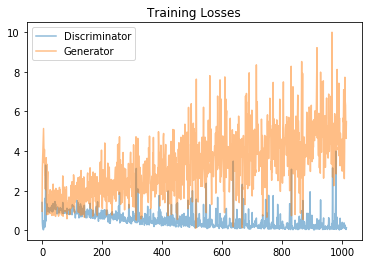

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

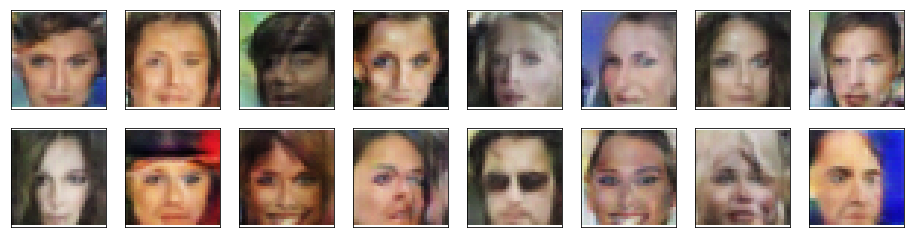

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

the generated images looking good and mostly have recognizble the features of a human_face But it has some blurry

to improve this model :
for dataset : it need to be more generalized and its better to contain face images of common people not only focus on white people
model size  :  incresing in model size and input image size will give better results but  that if  the  data images  have good quality.
Increasing number of epochs can give better outputs because that will decrease the generator loss.



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.